In [343]:
import os
import pandas as pd
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [344]:
from sklearn import metrics

# Load Data

## Load and set LFP tables

In [345]:
folder_path = osp.join('..','..','analysis')
path_to_free_enc_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_free.xlsx')

path_to_free_post_pre = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - PostEncounter-PreEncounter_free_4-12_30-80_free.xlsx')

path_to_free_lfp = osp.join(folder_path,
                            'lfp_rawdata_free.xlsx') 

In [346]:
filename = 'Population analysis results for video analysis of free interaction.xlsx'
full_file_name = osp.join(folder_path,'free', filename)

In [347]:
df_free_lfp_raw = pd.read_excel(path_to_free_lfp ,header=[0,1,2], index_col=[0])
df_free_enc_pre = pd.read_excel(path_to_free_enc_pre,None)
df_free_post_pre = pd.read_excel(path_to_free_post_pre,None)


In [348]:
import re

def fix_file_paths(df_files):
    
    df_files = df_files.rename(columns={df_files.columns[1]:'timestamps', df_files.columns[0]:'lfp', })
    
    return df_files



def extract_ratnum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"rat(\d{1,2})", filename.lower())

    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number

def extract_daynum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"day(\d{1,2})", filename.lower())
    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number
# rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]

area_num_to_name_map = {
    '111': 'MeD',
    '2': 'MePV',
    '13':'CeA',
    '112': 'BMA',
    '14': 'AA',
    '16': 'EA',
    '12': 'STIA',
    '15': 'VP'
}



def reformat_columns(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    freqs = df.columns.get_level_values('freq').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    for area in areas:
        for freq in freqs:
            for stage in stages:

                col_name = (area, freq, stage)
                
                area_name = area_num_to_name_map[area]
                if "diffduring" in stage.lower():
                    new_stage = 'enc_pre_lfp'
                elif"diffafter" in stage.lower():
                    new_stage = 'post_pre_lfp'
                else:
                    continue
                
                new_freq = freq.replace('-','_') + 'Hz'
                
                
                new_col_name = '_'.join((area_name, new_freq, new_stage))

                df_new[new_col_name] = df[col_name]
    return df_new


SPIKE_DATA_TYPE_SRC = 'diff'
SPIKE_DATA_TYPE_TARGET = 'spike_diff'


def reformat_columns_spikes(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    add_pre_sufix = 'ratio' in SPIKE_DATA_TYPE_TARGET or 'diff' in SPIKE_DATA_TYPE_TARGET
    suffix = 'pre_' if add_pre_sufix else ''
    for area in areas:
        for stage in stages:

            col_name = (area, stage)

            area_name = area_num_to_name_map[area]
            if SPIKE_DATA_TYPE_SRC+"during" in stage.lower():
                new_stage = 'enc_'+suffix+ SPIKE_DATA_TYPE_TARGET
            elif SPIKE_DATA_TYPE_SRC+"after" in stage.lower():
                new_stage = 'post_'+suffix+ SPIKE_DATA_TYPE_TARGET
            elif SPIKE_DATA_TYPE_SRC+"before" in stage.lower():
                new_stage = 'pre_'+ SPIKE_DATA_TYPE_TARGET
            else:
                continue

            

            new_col_name = '_'.join((area_name, new_stage))

            df_new[new_col_name] = df[col_name]
    return df_new

def reformat_columns_spikes_v2(df):
    # combine column names and remove levels
    df_new = pd.DataFrame()
    areas = df.columns.get_level_values('area').unique()
    stages = df.columns.get_level_values('stage').unique()

    df_new.index = df.index
    add_pre_sufix = 'ratio' in SPIKE_DATA_TYPE_TARGET or 'diff' in SPIKE_DATA_TYPE_TARGET
    suffix = 'enc' if add_pre_sufix else ''
    for area in areas:
        for stage in stages:

            col_name = (area, stage)

            area_name = area_num_to_name_map[area]
            if SPIKE_DATA_TYPE_SRC+"during" in stage.lower():
                during_data = df[col_name].dropna().values
            elif SPIKE_DATA_TYPE_SRC+"after" in stage.lower():
                after_data = df[col_name].dropna().values
            elif SPIKE_DATA_TYPE_SRC+"before" in stage.lower():
                before_data = df[col_name].dropna().values
            else:
                continue

            
        # create new column with calculation
        log_during_change = np.log(during_data) - np.log(before_data)
        
        
        new_stage = 'enc_pre_log_'+ SPIKE_DATA_TYPE_TARGET
        new_col_name = '_'.join((area_name, new_stage))
        df_new[new_col_name] = df[col_name]
        
        log_after_change = np.log(after_data) - np.log(before_data)
        new_stage = 'post_pre_log'+ SPIKE_DATA_TYPE_TARGET
        df_new[new_col_name] = df[col_name]
    return df_new
freq_keywords = {'First': '4_18Hz', 'Second':'30_80Hz'}
stage_keywords = {'During':'enc_pre', 'After':'post_pre'}
substrings_to_remove = ['During', 'After','Before', 'First', 'Second']
ignore_keyworks = ['Norm', 'files']

def remove_columns_with_fewer_values(df, N=5):
    # Get the count of non-null values in each column
    column_counts = df.count()

    # Filter columns based on count condition
    columns_to_remove = column_counts[column_counts < N].index

    # Drop the columns from the DataFrame
    updated_df = df.drop(columns=columns_to_remove)

    return updated_df

def reformat_dict_to_table(df_dict, file_df):
# def reformat_dict_to_table(df_dict, freq_keywords, stage_keywords, ignore_keyworks, substrings_to_remove):
    ret_df_list = []
    for sheet, df in df_dict.items():
        df = df.copy()
        # ignore first and last sheets that contain a summary and list of file names
        if any(substring in sheet for substring in ignore_keyworks): 
            continue
            
        if isinstance(df, str):
            print(df)
            continue
            
        if len(df) == 0:
            continue
        
         # Remove all substrings to keep just the area name
        area_name = sheet
        for sub_string_to_remove in substrings_to_remove:
            area_name = area_name.replace(sub_string_to_remove,'')
        
        for fk, freq in  freq_keywords.items():
            if fk in sheet:
                this_freq = freq_keywords[fk]
            for sk in stage_keywords.keys():
                if sk in sheet:
                    this_stage = stage_keywords[sk]
        
                # Rename all column names to match
        
        for col in df.columns:
            area_pair = [col, area_name]
            area_pair.sort()
            
            df.rename(columns={col:f'{area_pair[0]}_{area_pair[1]}_{this_freq}_{this_stage}'}, inplace=True)
        
        
        df.dropna(axis=1, how='all', inplace=True)
        df = remove_columns_with_fewer_values(df)
        ret_df_list.append(df)
        
    df_ret = pd.concat(ret_df_list,axis=1)
    df_ret['files'] = file_df.values
    return df_ret
                
            


# Fix column names
# change 4-12 to 4-18
def fix_range_name(s):
    return s.replace('4_18','4_12')
# if lfp is in the name, put it at the beggining
# if spike_ratio is in the name, put it at the beginning
def move_suffix_to_apx(s, sfx):
    if sfx in s:
        s = s.replace('_'+sfx, '')
        s = sfx+'_'+s
    return s

# if there is not lfp or skipe ration in the name, add coherence at the befinning
def add_cohherence(s):
    if 'lfp' not in s and 'spike' not in s and ('enc' in s or 'post' in s):
        s = 'coherence_' + s
    return s

# add number to catergorical variables to ensure that they are first
def add_number(s):
    if 'sociability' in s:
        s = '0_' + s
        
    elif 'rat_number' in s:
        s = '1_' + s
        
    elif 'day_number' in s:
        s = '2_' + s
    return s

def add_all_fix_functions(s):
    s = fix_range_name(s)
    s = move_suffix_to_apx(s, 'lfp')
    s = move_suffix_to_apx(s, SPIKE_DATA_TYPE_TARGET)
    s = add_cohherence(s)
#     s = add_number(s)
    return s


import re


def extract_ratnum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"rat(\d{1,2})", filename.lower())

    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number

def extract_daynum_from_file_name(filename):
    filename = filename.replace(' ','')
    match = re.search(r"day(\d{1,2})", filename.lower())
    if match:
        number = int(match.group(1))       
    else:
        number = -1
    return number






df_free_lfp = reformat_columns(df_free_lfp_raw)
df_files_free_bad = pd.read_excel(full_file_name,'Uploaded files', header=None)
df_files_free = fix_file_paths(df_files_free_bad)['lfp']

df_free_enc_pre_rectified = reformat_dict_to_table(df_free_enc_pre, df_files_free)
df_free_enc_post_rectified = reformat_dict_to_table(df_free_post_pre, df_files_free)
df_free = pd.concat([
    df_free_enc_pre_rectified.set_index('files'),
    df_free_enc_post_rectified.set_index('files'),
    df_free_lfp,
],
    axis=1)

df_free['sociability'] = 'free'

all_df = df_free
filenames = all_df.index.to_list()
all_df['rat_number'] = pd.Categorical([extract_ratnum_from_file_name(r) for r in filenames])
all_df['day_number'] = pd.Categorical([extract_daynum_from_file_name(r) for r in filenames])

all_df.rename(columns={c:add_all_fix_functions(c) for c in all_df.columns} , inplace=True)
all_df = all_df.reindex(sorted(all_df.columns), axis=1)

## Load and clean behavioral data


In [349]:
filename = 'Population analysis results for video analysis of free interaction.xlsx'
filepath = folder_path = osp.join('..','..','analysis')
full_file_name = osp.join(filepath,'free', filename)
df_dict = pd.read_excel(full_file_name,None)

# load all sheets
df_interactions = df_dict['ShortVsLongInteractions']
df_intervals = df_dict['ShortVsLongIntervals']
df_interactions_along_time = df_dict['InteractionAlongTime1SecBin']

[df_intervals.rename(columns={c:f'Intervals_{c}'.replace(' ','_')}, inplace=True) for c in df_intervals.columns]
[df_interactions.rename(columns={c:f'Interactions_{c}'.replace(' ','_')}, inplace=True) for c in df_interactions.columns]
df_comb = pd.concat([df_interactions,df_intervals], axis=1)


In [350]:
# add relative variables
df_interactions_cols = df_interactions.columns
df_interactions_total = 'Interactions_Total_time'

df_intervals_cols = df_intervals.columns
df_intervals_total = 'Intervals_All_intervals'

def add_ratio_to_behavioral(df_comb):
    skipping_vals = [df_intervals_total, df_interactions_total]

    for var in df_comb.columns:
        if var in skipping_vals or 'ratio' in var:
            continue
        
        if var in df_interactions_cols:
            divider = df_interactions_total
        elif var in df_intervals_cols:
            divider = df_intervals_total
        else:
            continue
        new_var_name = var+'_ratio'
        val = df_comb[var]/(df_comb[divider]+1)
        df_comb[new_var_name] = val

    return df_comb

In [351]:
df_comb = add_ratio_to_behavioral(df_comb)
df_comb['sessions'] = df_files_free
df_comb = df_comb.sample(frac=1)
df_files_free = df_comb['sessions']

In [352]:
df_sum = pd.DataFrame()
df_sum['sessions'] = df_files_free

df_sum['rat_number'] = df_sum['sessions'].apply(extract_ratnum_from_file_name)
df_sum['day_number'] = df_sum['sessions'].apply(extract_daynum_from_file_name)

# Cluster session by behavior

In [353]:
# vars_for_tsne = ['Interactions_Less_Than_6_sec_ratio',
#                 'Interactions_6_to_19_sec_ratio',
#                 'Interactions_More_Than_19_sec_ratio',
#                 'Intervals_Less_Than_5_sec_ratio',
#                 'Intervals_5_to_20_sec_ratio',
#                 'Intervals_More_Than_20_sec_ratio']


vars_for_tsne = ['Interactions_Less_Than_6_sec',
                 'Interactions_6_to_19_sec',
                 'Interactions_More_Than_19_sec',

                'Intervals_Less_Than_5_sec',
                'Intervals_5_to_20_sec',
                'Intervals_More_Than_20_sec']

In [354]:
# Extract data from behavioral data
# data_interactions = df_interactions.iloc[:,:3].values
# data_intervals = df_intervals.iloc[:,:3].values

# data_interactions = df_interactions
# data_intervals = df_intervals
# 

X_behavior = df_comb[vars_for_tsne].values

# X_behavior = np.concatenate([data_interactions,data_intervals],axis=1)
# X = data_interactions

In [355]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_behavior_scaled = scaler.fit_transform(X_behavior)


## Embeddings

In [356]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import warnings
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [357]:
# pca
pca = PCA(n_components=2).fit(X_behavior_scaled)

pca_comp = pca.fit_transform(X_behavior_scaled)
df_sum[['pca1','pca2']] = pca_comp

# sns.scatterplot(data=df_sum, x='pca1', y='pca2')

<Axes: xlabel='tsne1', ylabel='tsne2'>

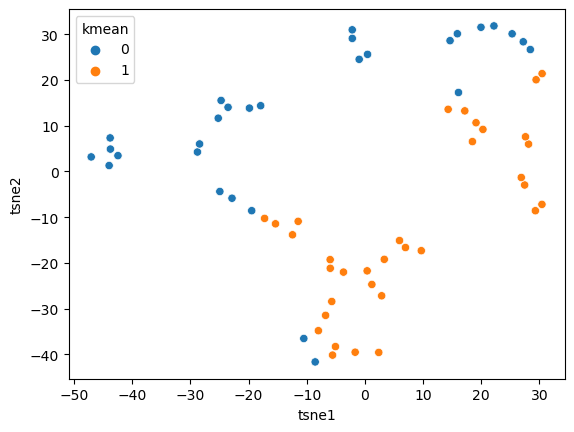

In [358]:
# TSNE embedding
X_TSNE = TSNE(n_components=2, learning_rate='auto',
                  init=pca_comp, perplexity=3).fit_transform(X_behavior_scaled)



df_sum[['tsne1','tsne2']] = X_TSNE
with warnings.catch_warnings(record=True):
    kmeans = KMeans(init=pca.components_, n_clusters=2, n_init=1)
    df_sum['kmean'] = kmeans.fit_predict(X_behavior_scaled)

# change label names
labels_map = {1:'affiliative', 0:'aversive'}
df_sum['kmean_labeled'] = df_sum['kmean'].apply(lambda x: labels_map[x])
sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='kmean')

In [359]:
# UMAP
X_umap = UMAP().fit_transform(X_behavior_scaled)
df_sum[['umap1','umap2']] = X_umap
# sns.scatterplot(data=df_sum, x='umap1', y='umap2')

### Cluster data

In [360]:
# DBSCANT
# db = DBSCAN(eps=2, min_samples=2).fit(X_behavior_scaled)
db = DBSCAN(eps=10, min_samples=5).fit(X_TSNE)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
df_sum['dbscan'] = db.fit_predict(X_TSNE)
# sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='dbscan')

Estimated number of clusters: 5
Estimated number of noise points: 4


In [361]:
# kmeans
kmeans = KMeans(init=pca.components_, n_clusters=2, n_init=1)
df_sum['kmean'] = kmeans.fit_predict(X_behavior_scaled)

# kmeans = KMeans(init="random", n_clusters=n_components, n_init=1)
# df_sum['kmean_labels_tsne'] = kmeans.fit_predict(X_behavior_embedded)
# sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='kmean_labels')

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



### Visualize clusters and embeddings

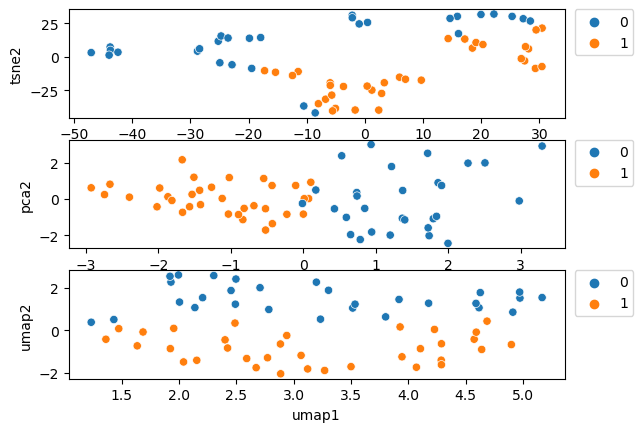

In [362]:
plt.subplot(3,1,1)
sns.scatterplot(data=df_sum, x='tsne1', y='tsne2', hue='kmean')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.subplot(3,1,2)
sns.scatterplot(data=df_sum, x='pca1', y='pca2', hue='kmean')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.subplot(3,1,3)
sns.scatterplot(data=df_sum, x='umap1', y='umap2', hue='kmean')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Run classification model on lfp data
## Load model

In [363]:
import pickle

# mopdel 1
folder_path = folder_path = osp.join('..','..','analysis')

best_model_path_1 = osp.join(folder_path,'best_model_20230626.sav')

best_model_dict_1 = pickle.load(open(best_model_path_1, 'rb'))
best_model_1 = best_model_dict_1['model']
best_imputer_1 = best_model_dict_1['imputer']
best_params_1 = best_model_dict_1['params']

# model 2
best_model_path_2 = osp.join(folder_path,'best_model_top4_20230626.sav')

best_model_dict_2 = pickle.load(open(best_model_path_2, 'rb'))
best_model_2 = best_model_dict_2['model']
best_imputer_2 = best_model_dict_2['imputer']
best_params_2 = best_model_dict_2['params']

## Make prediction

In [364]:
all_df = all_df.sample(frac=1)

In [365]:
best_params_1

['lfp_EA_30_80Hz_enc_pre',
 'lfp_AA_30_80Hz_enc_pre',
 'coherence_CeA_MeD_30_80Hz_post_pre',
 'coherence_AA_MeD_4_12Hz_enc_pre',
 'coherence_CeA_MeD_4_12Hz_enc_pre',
 'coherence_AA_MeD_30_80Hz_enc_pre',
 'coherence_CeA_MeD_4_12Hz_post_pre',
 'coherence_CeA_STIA_30_80Hz_enc_pre']

In [366]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Extract data
X = all_df[best_params_1].values # the parametes are the same for both models

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_imputed_1 = best_imputer_1.transform(X_scaled)
# X_imputed_1 = best_imputer_1.fit_transform(X_scaled)
y_pred_prob_mat = best_model_1.predict_proba(X_imputed_1)
y_pred_prob_1 = y_pred_prob_mat[:,0]
conf_pred = y_pred_prob_mat.max(axis=1)

X_imputed_2 = [imp.transform(X_scaled) for imp in best_imputer_2]
y_pred_prob_2 = [model.predict_proba(x)[:,0] for x, model in zip(X_imputed_2, best_model_2)]
y_pred_all = [model.predict(x) for x, model in zip(X_imputed_2, best_model_2)]
y_pred_2 = np.sum((np.array(y_pred_all)=='affiliative')*1, axis=0)>1
dict_vals = {True:'affiliative', False:'aversive'}
y_pred_2 = [dict_vals[v] for v in y_pred_2]
y_pred_prob_2 = np.median(np.array(y_pred_prob_2),axis=0)


In [522]:
all_df['y_pred_prob_1'] = y_pred_prob_1
all_df['y_pred_prob_2'] = y_pred_prob_2

In [368]:
th = 0.59
y_pred_1 = []
for a in  y_pred_prob_1 :
    c = 'affiliative' if a>th else 'aversive'
    y_pred_1.append(c)
    
# df_sum['model_pred_1'] = y_pred_1
# df_sum['model_pred_2'] = y_pred_2

all_df['model_pred_1'] = y_pred_1
all_df['model_pred_2'] = y_pred_2



In [369]:
th_1 = 0.2
th_2 = 0.6
y_pred_mix = []
for a in  y_pred_prob_1 :
    if a>=th_2:
        c = 'affiliative'
    elif a>=th_1:
        c = 'mix'
    else:
        c= 'aversive'
    
    y_pred_mix.append(c)
    
# df_sum['model_pred_mix'] = y_pred_mix

## Evaluate model


In [370]:
# all_df.reset_index()

In [371]:
# df_sum_ind = df_sum.set_index('sessions')
df_pred_data = all_df[['model_pred_1','y_pred_prob_1']]
# df_sum = df_sum.join(df_pred_data)
# df_sum = df_sum_ind

In [372]:
try:
    df_sum = df_sum.set_index('sessions')
except:
    pass

df_sum = df_sum.join(df_pred_data)

In [373]:
# df_sum

Best Threshold: 0.59 with G-Mean: 0.7164
FPR: 0.2414, TPR: 0.6765
({'F1': 0.71875, 'cappa': 0.4307228915662651, 'auc': 0.7352941176470588}, 0.59)


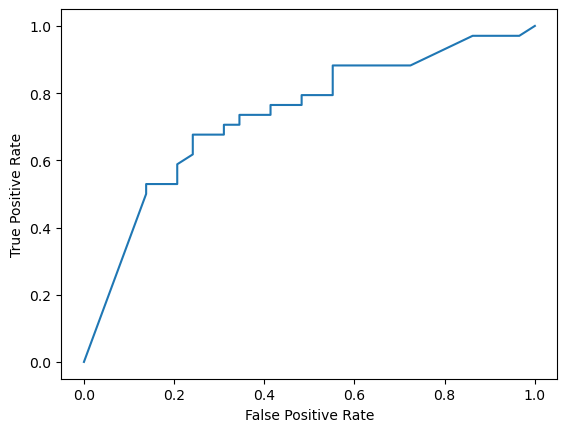

In [1215]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score


def eval_model(y_pred_prob,kmean_labels_logic,y_pred_labels=None):
    fpr, tpr, thresholds = roc_curve(kmean_labels_logic, y_pred_prob)
    gmean = np.sqrt(tpr * (1 - fpr))
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 

    # Calculate the G-mean
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    gmeanOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)
    print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
    print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
    
    if y_pred_labels is None:
        y_pred_labels = y_pred_prob>=thresholdOpt

    # kmean_labels_logic
    f1 = f1_score(kmean_labels_logic, y_pred_labels)
    cappa  = cohen_kappa_score(kmean_labels_logic, y_pred_labels)
    auc = roc_auc_score(kmean_labels_logic, y_pred_prob)
    df_performance = {'F1':f1,'cappa':cappa,'auc':auc}
    return df_performance, thresholdOpt

y_pred_labels = np.array(df_sum['model_pred_1'])=='affiliative'
# y_pred_labels = np.array(df_sum_ind['model_pred_1'])=='affiliative'
y_pred_prob = df_sum['y_pred_prob_1'].values
kmean_labels_logic = df_sum['kmean']==1
res_1 = eval_model(y_pred_prob, kmean_labels_logic)
print(res_1)

In [375]:
np.sum(kmean_labels_logic==y_pred_labels)/len(y_pred_labels)

0.6984126984126984

# visualize results


[]

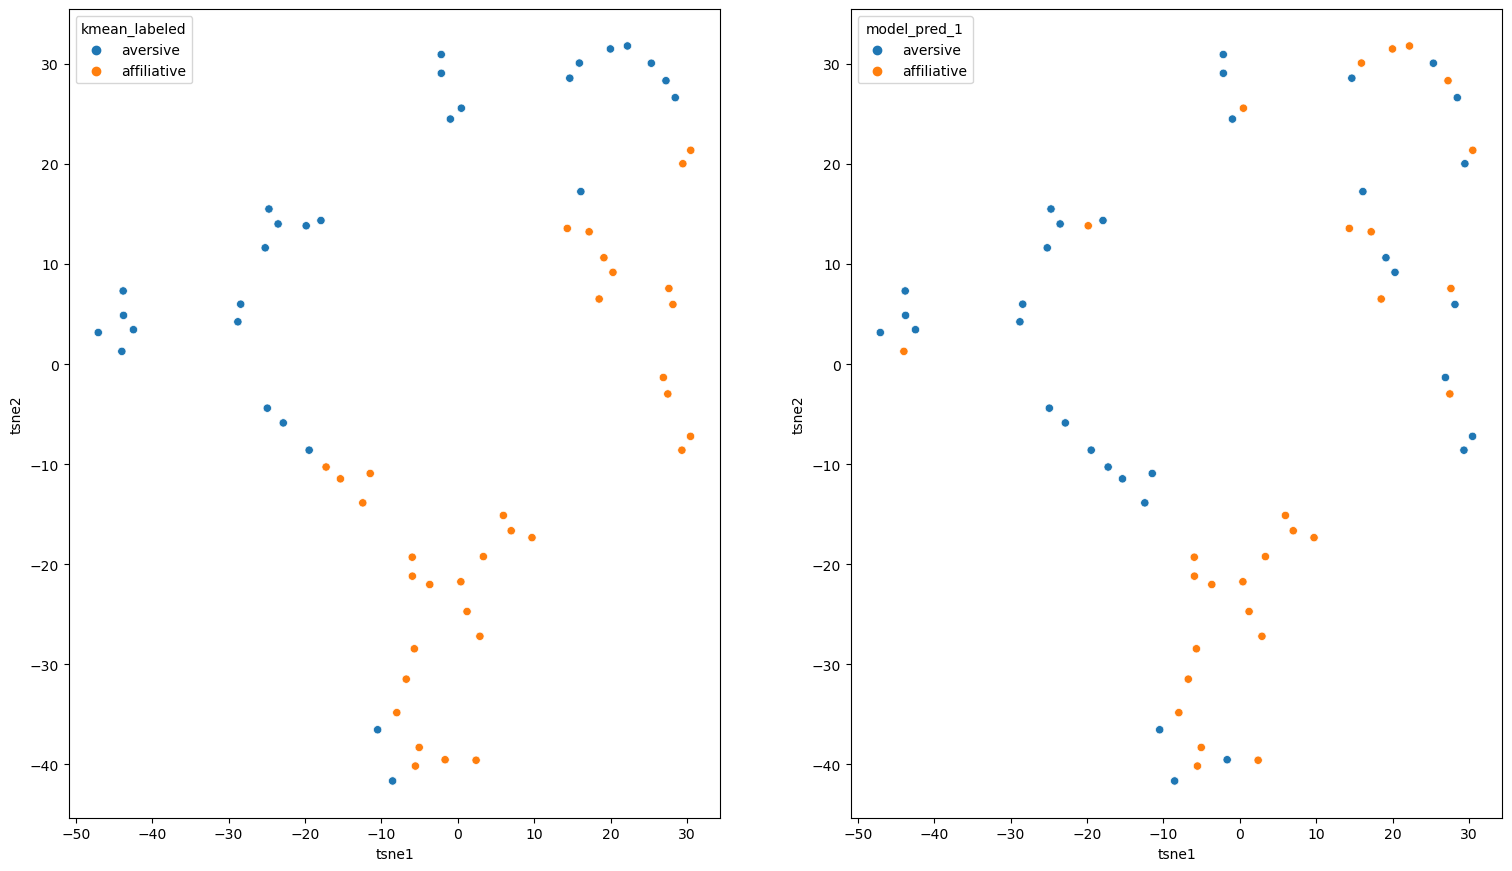

In [376]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18.5, 10.5)


var1 = 'tsne1'
var2 = 'tsne2'

# var1 = 'pca1'
# var2 = 'pca2'

# cluster_name = 'dbscan'
cluster_name = 'kmean_labeled'

# sns.scatterplot(ax=ax1, data=df_sum, x=var1, y=var2, hue='model_pred_2')
sns.scatterplot(ax=ax1, data=df_sum, x=var1, y=var2, hue=cluster_name)
sns.scatterplot(ax=ax2, data=df_sum, x=var1, y=var2, hue='model_pred_1')

plt.plot()

In [377]:
df_sum['pred_conf'] = conf_pred

In [378]:
# sns.relplot(x=var1, y=var2, hue="model_pred_1", size=conf_pred,
#             sizes=(40, 400),
#             height=6, data=df_sum)

In [379]:
import ipywidgets as widgets
%matplotlib inline


In [380]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# To display the plots directly in the Jupyter Notebook
%matplotlib inline


var1 = 'tsne1'
var2 = 'tsne2'

# Set the initial threshold value
initial_threshold = 0.59

# Create a slider widget
slider = widgets.FloatSlider(min=0.0, max=1, step=0.001, value=initial_threshold)

# Define the update function
def update_plot(threshold):
    y_pred = []
    for a in y_pred_prob_1:
        c = 'affiliative' if a > threshold else 'aversive'
        y_pred.append(c)

    # Update the 'model_pred' column in the DataFrame
    df_sum['model_pred'] = y_pred

    # Clear the previous plot
#     plt.clf()

    # Create a new figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)

    # Update the plot data and properties
    sns.scatterplot(ax=ax1, data=df_sum, x=var1, y=var2, hue='kmean_labeled', palette={'affiliative': 'blue', 'aversive': 'orange', 'between': 'green'})
    sns.scatterplot(ax=ax2, data=df_sum, x=var1, y=var2, hue='model_pred', palette={'affiliative': 'blue', 'aversive': 'orange'})

    # Show the updated plot
    plt.show()

# Register the update function to the slider's value change event
widgets.interact(update_plot, threshold=slider)

# Display the slider
display(slider)



interactive(children=(FloatSlider(value=0.59, description='threshold', max=1.0, step=0.001), Output()), _dom_c…

FloatSlider(value=0.59, description='threshold', max=1.0, step=0.001)

In [381]:
# import sweetviz as sv
# #EDA using Autoviz
# df_vis = df
# # df_vis = df_vis[[c for c in df_vis.columns if c not in cat_vars]]

# # df_vis = df_vis.apply(pd.to_numeric)
# # df_vis['sociability'] = df_coherence_data['sociability']

# # feature_config = sv.FeatureConfig(force_num=[c for c in df_vis.columns if c not in cat_vars])
# sweet_report = sv.compare_intra(
#     df_vis,df_vis['model_pred']=='affiliative',
#     ['affiliative', 'aversive'],
# #     feat_cfg=feature_config
# )

# #Saving results to HTML file
# sweet_report.show_html('df_free.html')
# # sweet_report.show_notebook(filepath='sweet_report.html')

In [382]:
df = pd.concat([df_comb, df_sum], axis=1)

In [383]:
df.columns

Index(['Interactions_Less_Than_6_sec', 'Interactions_6_to_19_sec',
       'Interactions_More_Than_19_sec', 'Interactions_More_than_6_sec',
       'Interactions_Total_time', 'Intervals_Less_Than_5_sec',
       'Intervals_5_to_20_sec', 'Intervals_More_Than_20_sec',
       'Intervals_All_intervals', 'Interactions_Less_Than_6_sec_ratio',
       'Interactions_6_to_19_sec_ratio', 'Interactions_More_Than_19_sec_ratio',
       'Interactions_More_than_6_sec_ratio', 'Intervals_Less_Than_5_sec_ratio',
       'Intervals_5_to_20_sec_ratio', 'Intervals_More_Than_20_sec_ratio',
       'sessions', 'rat_number', 'day_number', 'pca1', 'pca2', 'tsne1',
       'tsne2', 'kmean', 'kmean_labeled', 'umap1', 'umap2', 'dbscan',
       'model_pred_1', 'y_pred_prob_1', 'pred_conf', 'model_pred'],
      dtype='object')

In [384]:
# import plotly.graph_objs as go
# import plotly.offline as py
# import plotly.express as px

# import pandas as pd
# import numpy as np
# from ipywidgets import interactive, HBox, VBox, Button

# py.init_notebook_mode()


# # var_x = 'umap1'
# # var_y = 'umap2'

# var_y = 'tsne2'
# var_x = 'tsne1'
# hue_column = 'model_pred_1'
# # hue_column = 'kmean_labeled'
# # hue_column = 'model_pred_mix'

# color_mapping = {
#     'affiliative': 'blue',
#     'aversive': 'red',
#     'mix': 'green'
# }
# colors = [color_mapping[val] for val in df[hue_column].values]

# values = ['sessions','rat_number','day_number','model_pred_1','kmean_labeled',
#     'Interactions_Less_Than_6_sec', 'Interactions_6_to_19_sec', 'Interactions_More_Than_19_sec',
#           'Interactions_More_than_6_sec',
#        'Interactions_Total_time', 'Intervals_Less_Than_5_sec',
#           'Intervals_5_to_20_sec', 'Intervals_More_Than_20_sec',
#        'Intervals_All_intervals','pred_conf']

# f = go.FigureWidget([go.Scatter(y = df[var_y], x = df[var_x], mode = 'markers', marker=dict(
#         color=colors,
#         colorscale='Viridis',  # Choose the desired color scale
#         showscale=True,
#         size = conf_pred*10
    
#     ))])
# scatter = f.data[0]
# N = len(df)
# # scatter.x = scatter.x + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
# # scatter.y = scatter.y + np.random.rand(N)/10 *(df['City mpg'].max() - df['City mpg'].min())
# # scatter.marker.opacity = 0.5

# def update_axes(xaxis, yaxis):
#     scatter = f.data[0]
#     scatter.x = df[xaxis]
#     scatter.y = df[yaxis]
#     with f.batch_update():
#         f.layout.xaxis.title = xaxis
#         f.layout.yaxis.title = yaxis
# #         scatter.x = scatter.x + np.random.rand(N)/10 *(df[xaxis].max() - df[xaxis].min())
# #         scatter.y = scatter.y + np.random.rand(N)/10 *(df[yaxis].max() - df[yaxis].min())

# axis_dropdowns = interactive(
# #     update_axes, yaxis = df.select_dtypes('int64').columns, xaxis = df.select_dtypes('int64').columns)
#     update_axes, yaxis = df.columns, xaxis = df.columns)

# # Create a table FigureWidget that updates on selection from points in the scatter plot of f
# go_tab = go.Table(
#     header=dict(values=values,
#                 fill = dict(color='#C2D4FF'),
#                 align = ['left'] * 5),
#     cells=dict(values=[df[col] for col in values],
#                fill = dict(color='#F5F8FF'),
#                align = ['left'] * 5))
# t = go.FigureWidget([go_tab])

# def selection_fn(trace,points,selector):
#     t.data[0].cells.values = [df.loc[points.point_inds][col] for col in values]
# #     print(df.loc[points.point_inds][values])
# scatter.on_selection(selection_fn)


# def copy_to_clipboard(btn):
#     df_selected = df.iloc[list(scatter.selectedpoints)][values]
# #     csv_data = df_selected.to_csv(index=False)
# #     clipboard.copy(csv_data)
#     df_selected.to_clipboard()
#     print("Data copied to clipboard")

# scatter.on_selection(selection_fn)

# # Create the button to copy data to clipboard
# copy_button = Button(description='Copy to Clipboard',)
# copy_button.on_click(copy_to_clipboard)

# # Put everything together
# VBox((HBox(axis_dropdowns.children), copy_button, f, t))

In [385]:
# go_table_vals = go_tab.to_plotly_json()['cells']['values']
# go_table_headers = go_tab.to_plotly_json()['header']['values']
# pd.DataFrame(zip(*go_table_vals), columns=go_table_headers)

In [386]:
df_clusters = pd.read_excel(osp.join(folder_path,'clustering_of_free_rats_based_on_tsne.xlsx'),'clusters2')
for var in df_clusters.columns:
    new_name = var.replace(' ','_')
    df_clusters.rename(columns={var:new_name}, inplace=True)

In [387]:
# df_vis = df_clusters
# # df_vis = df_vis[[c for c in df_vis.columns if c not in cat_vars]]

# # df_vis = df_vis.apply(pd.to_numeric)
# # df_vis['sociability'] = df_coherence_data['sociability']

# # feature_config = sv.FeatureConfig(force_num=[c for c in df_vis.columns if c not in cat_vars])
# sweet_report = sv.compare_intra(
#     df_vis,df_vis['model_pred']=='affiliative',
#     ['affiliative', 'aversive'],
# #     feat_cfg=feature_config
# )

# #Saving results to HTML file
# sweet_report.show_html('df_free.html')
# # sweet_report.show_notebook(filepath='sweet_report.html')

In [1171]:
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu

def compare_groups(df, grouper):
    # Create an empty DataFrame to store the results
    significance_table = pd.DataFrame(columns=['variable', 'statistic', 'pvalue'])
    
    # Iterate over each numeric variable in the DataFrame
    for column in df.select_dtypes(include='number'):
        if column ==grouper:
            continue
        groups = [group[column] for _, group in df.groupby(grouper)]
        
        # Perform the statistical test (e.g., one-way ANOVA)
#         statistic, pvalue = stats.f_oneway(*groups)
        
        statistic, pvalue = mannwhitneyu(*groups)
        
        # Append the results to the significance table
        significance_table = significance_table.append({'variable': column, 'statistic': statistic, 'pvalue': pvalue}, ignore_index=True)
    
    # Sort the significance table by p-value in ascending order
    significance_table = significance_table.sort_values(by='pvalue')
    
    return significance_table


In [389]:
df_clusters_ratios = add_ratio_to_behavioral(df_clusters)

In [390]:
# df_clusters_ratios

In [391]:
vals_to_drop = set(['cluster','tsne1','tsne2','Unnamed:_0_ratio', 'Unnamed:_0']) - (set(['cluster','tsne1','tsne2','Unnamed:_0_ratio', 'Unnamed:_0'])-set(df_clusters_ratios.columns))

In [392]:
import warnings
with warnings.catch_warnings(record=True):
    sig_tab = compare_groups(df_clusters_ratios.drop(vals_to_drop,axis=1),grouper='model_pred_1')

In [393]:
sig_tab

,variable,statistic,pvalue
2,Interactions_Less_Than_6_sec,6.267327,0.014991
8,Intervals_5_to_20_sec,5.824350,0.018824
7,Intervals_Less_Than_5_sec,4.900252,0.030602
17,Intervals_More_Than_20_sec_ratio,4.293840,0.042485
16,Intervals_5_to_20_sec_ratio,4.270372,0.043035
9,Intervals_More_Than_20_sec,4.243971,0.043663
6,Interactions_Total_time,4.015497,0.049530
3,Interactions_6_to_19_sec,2.253962,0.138432
10,Intervals_All_intervals,1.893765,0.173809
15,Intervals_Less_Than_5_sec_ratio,0.938948,0.336375


In [394]:
top_vars = sig_tab.loc[sig_tab['pvalue']<0.1]['variable'].values
# top_vars = vars_for_tsne
top_vars = list(top_vars)
print(top_vars)
top_vars.append('cluster')


['Interactions_Less_Than_6_sec', 'Intervals_5_to_20_sec', 'Intervals_Less_Than_5_sec', 'Intervals_More_Than_20_sec_ratio', 'Intervals_5_to_20_sec_ratio', 'Intervals_More_Than_20_sec', 'Interactions_Total_time']


In [395]:
X_behavior_top = df_clusters[top_vars].drop('cluster', axis=1).values
scaler = StandardScaler()
X_behavior_top_scaled = scaler.fit_transform(X_behavior_top)
X_tsne_embed_top = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_behavior_top_scaled)
df_clusters[['tsne1','tsne2']] = X_tsne_embed_top

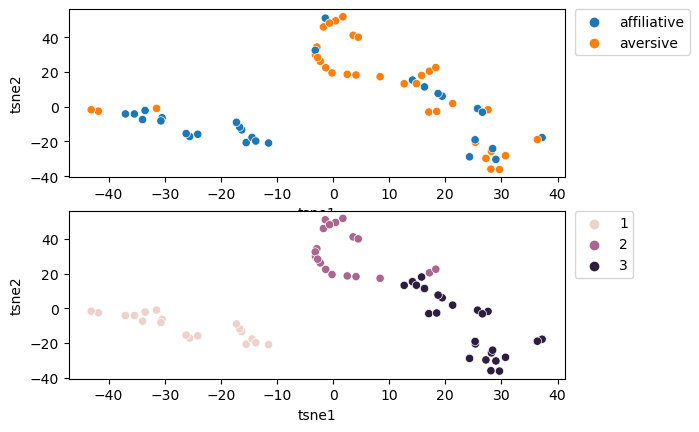

In [396]:
plt.subplot(2,1,1)
sns.scatterplot(data=df_clusters, x='tsne1', y='tsne2', hue='model_pred_1')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.subplot(2,1,2)
sns.scatterplot(data=df_clusters, x='tsne1', y='tsne2', hue='cluster')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [397]:
vars_to_show = list(set(top_vars+['model_pred_1']+['Interactions_Total_time']+['Intervals_All_intervals']))
vars_to_show.sort()


In [398]:
# top_vars.append('model_pred_1')
# sns.pairplot(df_clusters.loc[df_clusters['cluster'].isin([1,2])][vars_to_show], hue='model_pred_1')
# sns.pairplot(df_clusters[vars_to_show], hue='model_pred_1', kind='reg')
# sns.pairplot(df_clusters[vars_to_show+['kmean_labeled']], hue='kmean_labeled', kind='reg')

In [399]:
# sns.pairplot(df_clusters[vars_to_show+['kmean_labeled']], hue='model_pred_1', kind='reg')

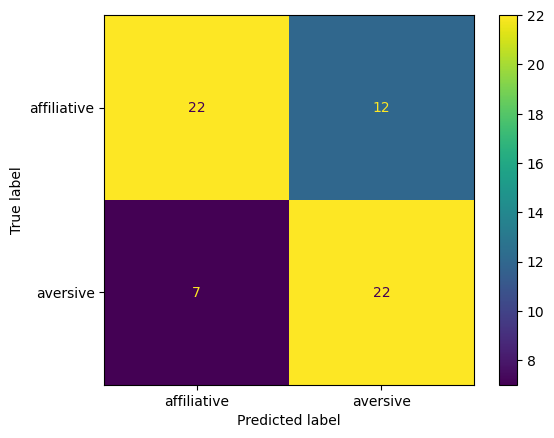

In [400]:
y_pred_labels = df_sum['model_pred_1'].values
kmean_labels_logic = df_sum['kmean_labeled'].values

cm = confusion_matrix(kmean_labels_logic, y_pred_labels, labels=['affiliative','aversive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['affiliative','aversive'])
disp.plot()


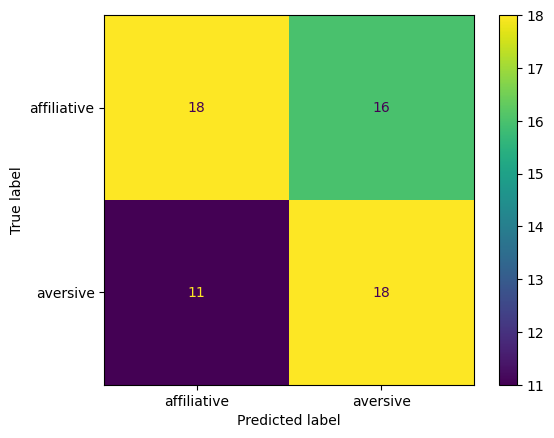

In [401]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
dict_vals = {True:'affiliative', False:'aversive'}
th_1 = 0.05
th_2 = 0.6
th_3 = 60
# logical_labels = (df_clusters['Intervals_More_Than_20_sec_ratio']>th_1)\
# logical_labels = (df_clusters['Intervals_5_to_20_sec_ratio']<th_2)\
#                 |(df_clusters['Interactions_Less_Than_6_sec']>th_3)

diff_var = (df_clusters['Intervals_More_Than_20_sec'].values)/(df_clusters['Interactions_Total_time'].values+1)
logical_labels = (diff_var>0.1794)
variable_labels = [dict_vals[l] for l in logical_labels]
cm = confusion_matrix(variable_labels, y_pred_1, labels=list(dict_vals.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(dict_vals.values()))
disp.plot()


In [402]:
diff_var[np.argmax(diff_var)] = 0

<Axes: >

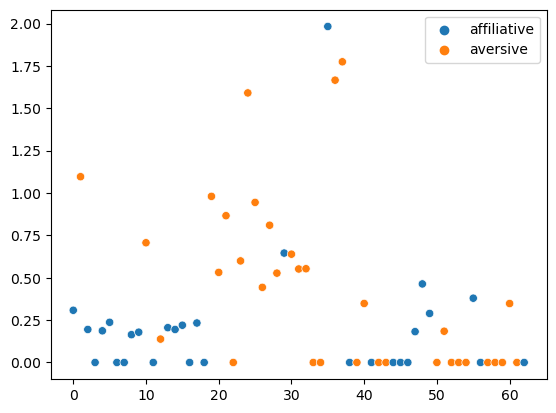

In [403]:
sns.scatterplot(x=range(len(diff_var)), y=diff_var, hue=df_clusters['model_pred_1'].values)

In [404]:
# scaler = StandardScaler()
# X_behavior_scaled_scaled = scaler.fit_transform(X_behavior_scaled.transpose()).transpose()
# df_heat = pd.DataFrame(zip(*X_behavior_scaled_scaled)).transpose()

# df_heat = pd.DataFrame(zip(*X_behavior_scaled)).transpose()
# df_heat = df_heat.rename(columns={a:name for a, name in  enumerate(vars_for_tsne)})


df_heat = pd.DataFrame(zip(*X_behavior_top_scaled)).transpose()
df_heat = df_heat.rename(columns={a:name for a, name in  enumerate(top_vars)})


# df_heat['sessions'] = df_sum['sessions']
df_heat['sessions'] = df_sum.index
df_heat['kmean_labeled'] = df_sum['kmean_labeled'].values
df_heat['correct'] = (df_sum['model_pred_1'] == df_sum['kmean_labeled'])*1
df_heat = pd.concat([df_heat.set_index('sessions'), df_clusters[['cluster','model_pred_1','sessions']].set_index('sessions')],axis=1)

In [405]:
top_vars

['Interactions_Less_Than_6_sec',
 'Intervals_5_to_20_sec',
 'Intervals_Less_Than_5_sec',
 'Intervals_More_Than_20_sec_ratio',
 'Intervals_5_to_20_sec_ratio',
 'Intervals_More_Than_20_sec',
 'Interactions_Total_time',
 'cluster']

In [406]:
sort_vars = vars_for_tsne.copy()
sort_vars.reverse()
sort_vars.insert(0, 'cluster')


<Axes: ylabel='sessions'>

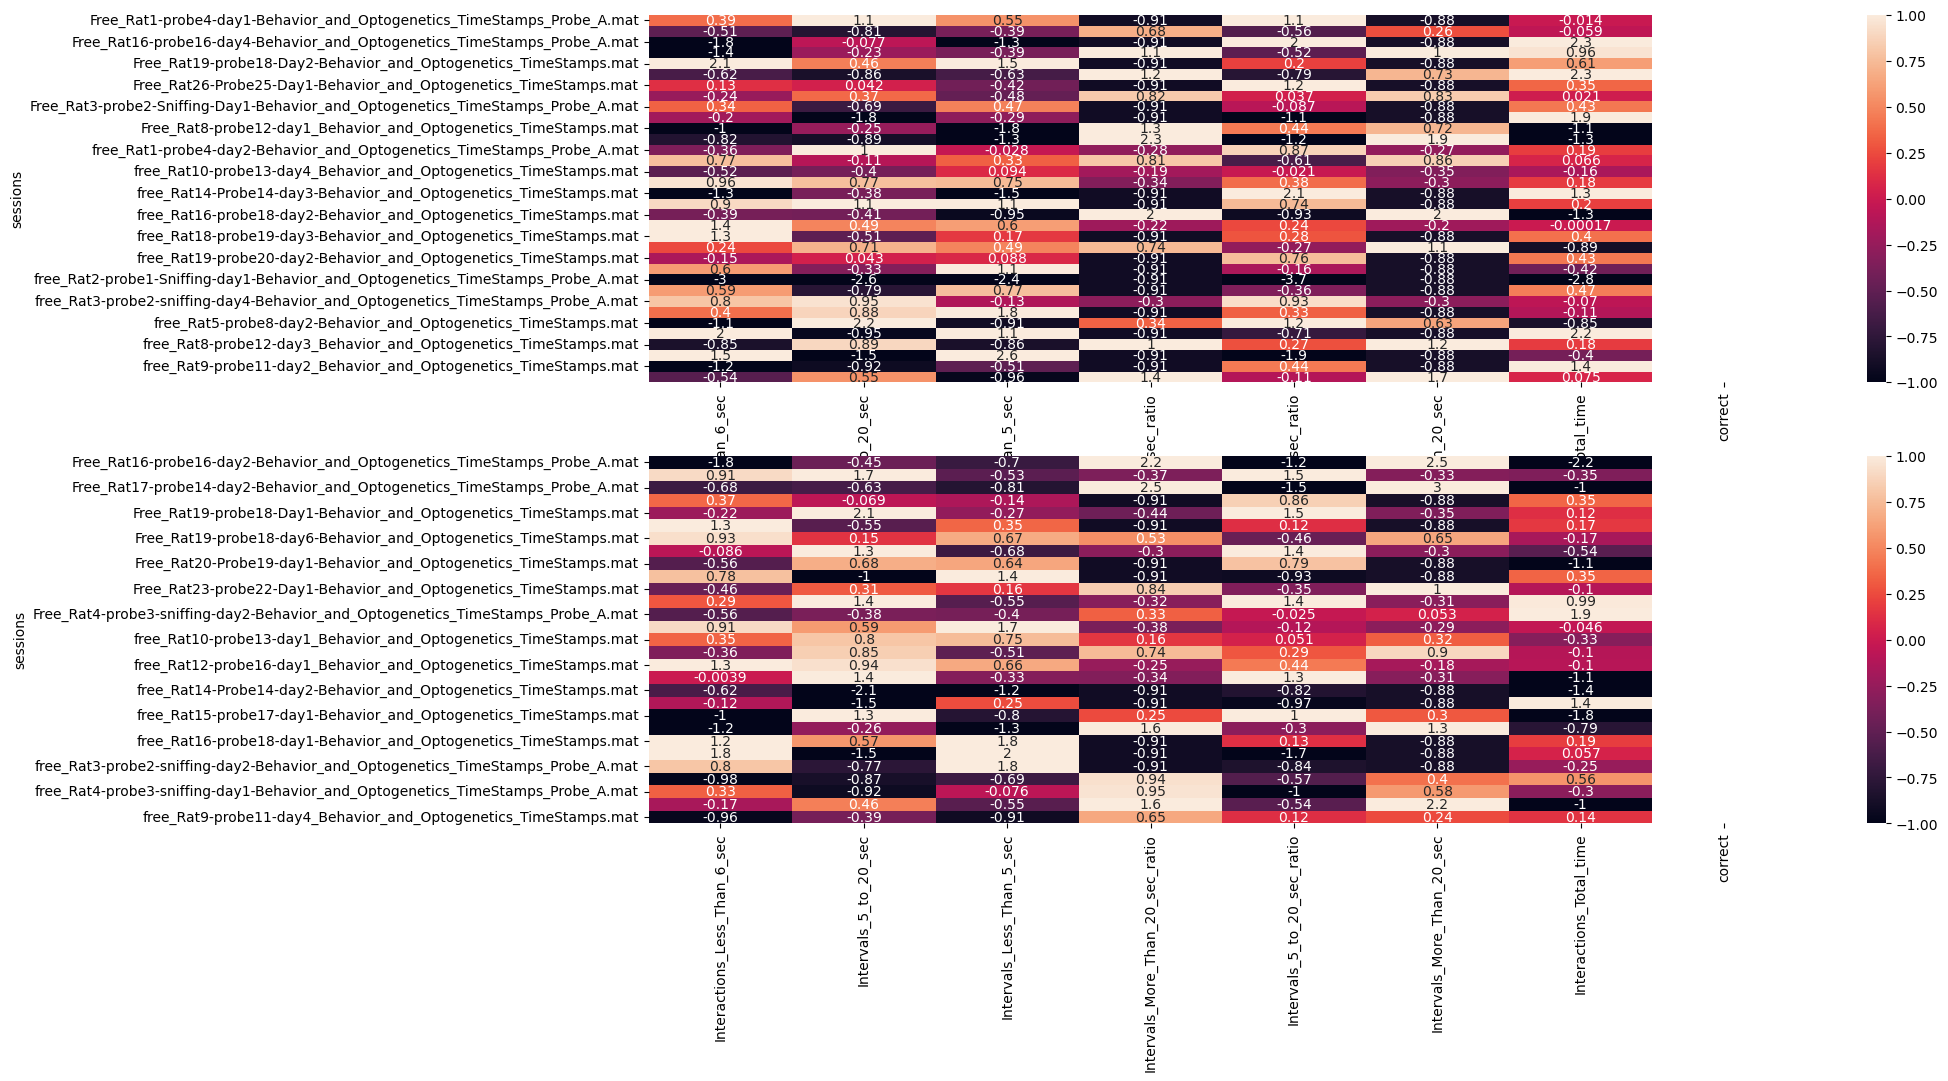

In [407]:
# df_heat = df_heat.loc[df_heat['correct']==1]
# df_heat = df_heat.loc[df_heat['cluster'].isin([1,2])]


df_heat = df_heat.sort_values(['sessions'])
# df_heat_aff = df_heat.loc[df_heat['model_pred_1']=='affiliative']
# df_heat_avv = df_heat.loc[df_heat['model_pred_1']=='aversive']

df_heat_aff = df_heat.loc[df_heat['kmean_labeled']=='affiliative']
df_heat_avv = df_heat.loc[df_heat['kmean_labeled']=='aversive']
df_heat_aff = df_heat_aff.sort_values(['sessions'])
df_heat_avv = df_heat_avv.sort_values(['sessions'])
min_val = -1
max_val = 1
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.subplot(2,1,1)
sns.heatmap(data=df_heat_aff.drop(['cluster','kmean_labeled','model_pred_1'], axis=1).sort_values('correct'),vmin=min_val, vmax=max_val, annot=True)

plt.subplot(2,1,2)
sns.heatmap(data=df_heat_avv.drop(['cluster','kmean_labeled','model_pred_1'], axis=1).sort_values('correct'),vmin=min_val, vmax=max_val, annot=True)

In [408]:
df_heat_aff.describe()

,Interactions_Less_Than_6_sec,Intervals_5_to_20_sec,Intervals_Less_Than_5_sec,Intervals_More_Than_20_sec_ratio,Intervals_5_to_20_sec_ratio,Intervals_More_Than_20_sec,Interactions_Total_time,correct,cluster
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,0.0,34.000000
mean,-0.047657,-0.090274,-0.050940,-0.083265,0.012059,-0.099986,0.194510,NaN,1.882353
std,1.114252,0.969542,1.067481,1.014316,1.078964,0.961776,1.081158,NaN,0.945955
min,-2.999947,-2.633129,-2.389508,-0.908979,-3.656830,-0.881357,-2.787433,NaN,1.000000
25%,-0.768250,-0.764296,-0.805256,-0.908979,-0.551875,-0.881357,-0.150396,NaN,1.000000
50%,-0.177151,-0.167800,-0.077312,-0.623791,0.120117,-0.613954,0.127712,NaN,1.500000
75%,0.725451,0.669116,0.589903,0.793050,0.667972,0.723909,0.457631,NaN,3.000000
max,2.078569,2.211038,2.584918,2.332495,2.063389,2.035622,2.338725,NaN,3.000000


In [409]:
df_heat_avv.describe()

,Interactions_Less_Than_6_sec,Intervals_5_to_20_sec,Intervals_Less_Than_5_sec,Intervals_More_Than_20_sec_ratio,Intervals_5_to_20_sec_ratio,Intervals_More_Than_20_sec,Interactions_Total_time,correct,cluster
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,0.0,29.000000
mean,0.055874,0.105838,0.059723,0.097621,-0.014138,0.117225,-0.228046,NaN,2.344828
std,0.883597,1.058599,0.948764,1.009531,0.936785,1.064628,0.878954,NaN,0.613879
min,-1.772848,-2.067380,-1.301871,-0.908979,-1.714379,-0.881357,-2.187300,NaN,1.000000
25%,-0.559930,-0.632778,-0.679102,-0.908979,-0.816525,-0.881357,-0.787508,NaN,2.000000
50%,-0.085785,0.146416,-0.267233,-0.297258,-0.025267,-0.291719,-0.103404,NaN,2.000000
75%,0.804213,0.848641,0.659189,0.744444,0.785518,0.581350,0.168544,NaN,3.000000
max,1.848585,2.091224,1.962149,2.542867,1.506700,2.975330,1.878034,NaN,3.000000


C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



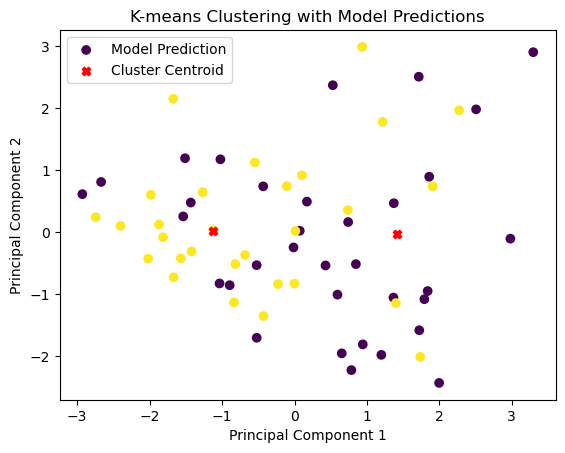

Sample Features: [-0.54260111  0.81451727 -0.43344932 -0.9617765   0.54712007  1.67711449]
Centroid Features: [-0.8719352   0.22286643  0.397443   -0.78486789 -0.333439    0.58487455]
Neighboring Samples:
Sample 62: Cluster 1
Sample 52: Cluster 1
Sample 8: Cluster 1
Sample 58: Cluster 1
Sample 12: Cluster 1


In [410]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your data is stored in the 'data' variable
data = X_behavior_scaled  # Replace '...' with your dataset

k = 2  # Number of clusters

# Assuming your model predictions are stored in the 'model_predictions' variable
model_predictions = 1*(df_sum['model_pred_1'].values=='affiliative')+1  # Replace '...' with your model predictions

# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

# Get the cluster labels assigned to each sample
cluster_labels = kmeans.labels_

# Access the centroids of each cluster
centroids = kmeans.cluster_centers_

# Perform dimensionality reduction for visualization (assuming 2D plot)
pca = PCA(n_components=2)
data_transformed = pca.fit_transform(data)
centroids_transformed = pca.transform(centroids)

# Plot the data points and cluster centroids with color-coded labels
plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=model_predictions, label='Model Prediction')
plt.scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], c='red', marker='X', label='Cluster Centroid')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with Model Predictions')
plt.legend()
plt.show()

# Choose a specific sample for interpretation
sample_index = 0  # Replace with the index of the sample you want to interpret

# Get the assigned cluster label for the sample
sample_cluster = cluster_labels[sample_index]

# Compare sample features with centroid features
sample_features = data[sample_index]
centroid_features = centroids[sample_cluster]

# Print feature values of the sample and centroid
print("Sample Features:", sample_features)
print("Centroid Features:", centroid_features)

# Calculate the Euclidean distance between the sample and centroids
distances = np.linalg.norm(data - centroid_features, axis=1)

# Sort samples based on their distances to centroids
sorted_indices = np.argsort(distances)

# Find the closest neighboring samples to the target sample
neighboring_samples = sorted_indices[:5]  # Adjust the number of neighboring samples as desired

# Print the neighboring samples and their assigned clusters
print("Neighboring Samples:")
for index in neighboring_samples:
    print(f"Sample {index}: Cluster {cluster_labels[index]}")


C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



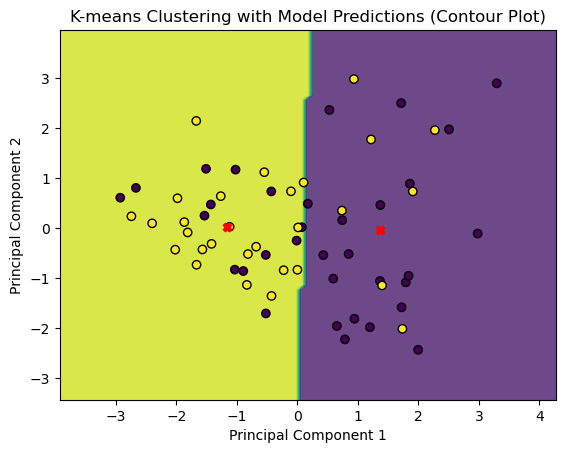

Sample Features: [-0.54260111  0.81451727 -0.43344932 -0.9617765   0.54712007  1.67711449]
Centroid Features: [-0.83043237  0.20829996  0.36879155 -0.76043135 -0.35382992  0.584753  ]
Neighboring Samples:
Sample 52: Cluster 0
Sample 62: Cluster 0
Sample 8: Cluster 0
Sample 58: Cluster 0
Sample 12: Cluster 0


In [411]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your data is stored in the 'data' variable
data = X_behavior_scaled  # Replace '...' with your dataset

k = 2  # Number of clusters

# Assuming your model predictions are stored in the 'model_predictions' variable
model_predictions = 1*(df_sum['model_pred_1']=='affiliative')  # Replace '...' with your model predictions

# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

# Get the cluster labels assigned to each sample
cluster_labels = kmeans.labels_

# Access the centroids of each cluster
centroids = kmeans.cluster_centers_

# Perform dimensionality reduction for visualization (assuming 2D plot)
pca = PCA(n_components=2)
data_transformed = pca.fit_transform(data)
centroids_transformed = pca.transform(centroids)

# Create a meshgrid for the contour plot
x_min, x_max = data_transformed[:, 0].min() - 1, data_transformed[:, 0].max() + 1
y_min, y_max = data_transformed[:, 1].min() - 1, data_transformed[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict the labels for the meshgrid points
mesh_predictions = kmeans.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

# Reshape the predicted labels into the meshgrid shape
mesh_predictions = mesh_predictions.reshape(xx.shape)

# Plot the contour plot with color-coded labels
plt.contourf(xx, yy, mesh_predictions, alpha=0.8)
plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=model_predictions, edgecolors='k')
plt.scatter(centroids_transformed[:, 0], centroids_transformed[:, 1], c='red', marker='X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with Model Predictions (Contour Plot)')
plt.show()

# Choose a specific sample for interpretation
sample_index = 0  # Replace with the index of the sample you want to interpret

# Get the assigned cluster label for the sample
sample_cluster = cluster_labels[sample_index]

# Compare sample features with centroid features
sample_features = data[sample_index]
centroid_features = centroids[sample_cluster]

# Print feature values of the sample and centroid
print("Sample Features:", sample_features)
print("Centroid Features:", centroid_features)

# Calculate the Euclidean distance between the sample and centroids
distances = np.linalg.norm(data - centroid_features, axis=1)

# Sort samples based on their distances to centroids
sorted_indices = np.argsort(distances)

# Find the closest neighboring samples to the target sample
neighboring_samples = sorted_indices[:5]  # Adjust the number of neighboring samples as desired

# Print the neighboring samples and their assigned clusters
print("Neighboring Samples:")
for index in neighboring_samples:
    print(f"Sample {index}: Cluster {cluster_labels[index]}")


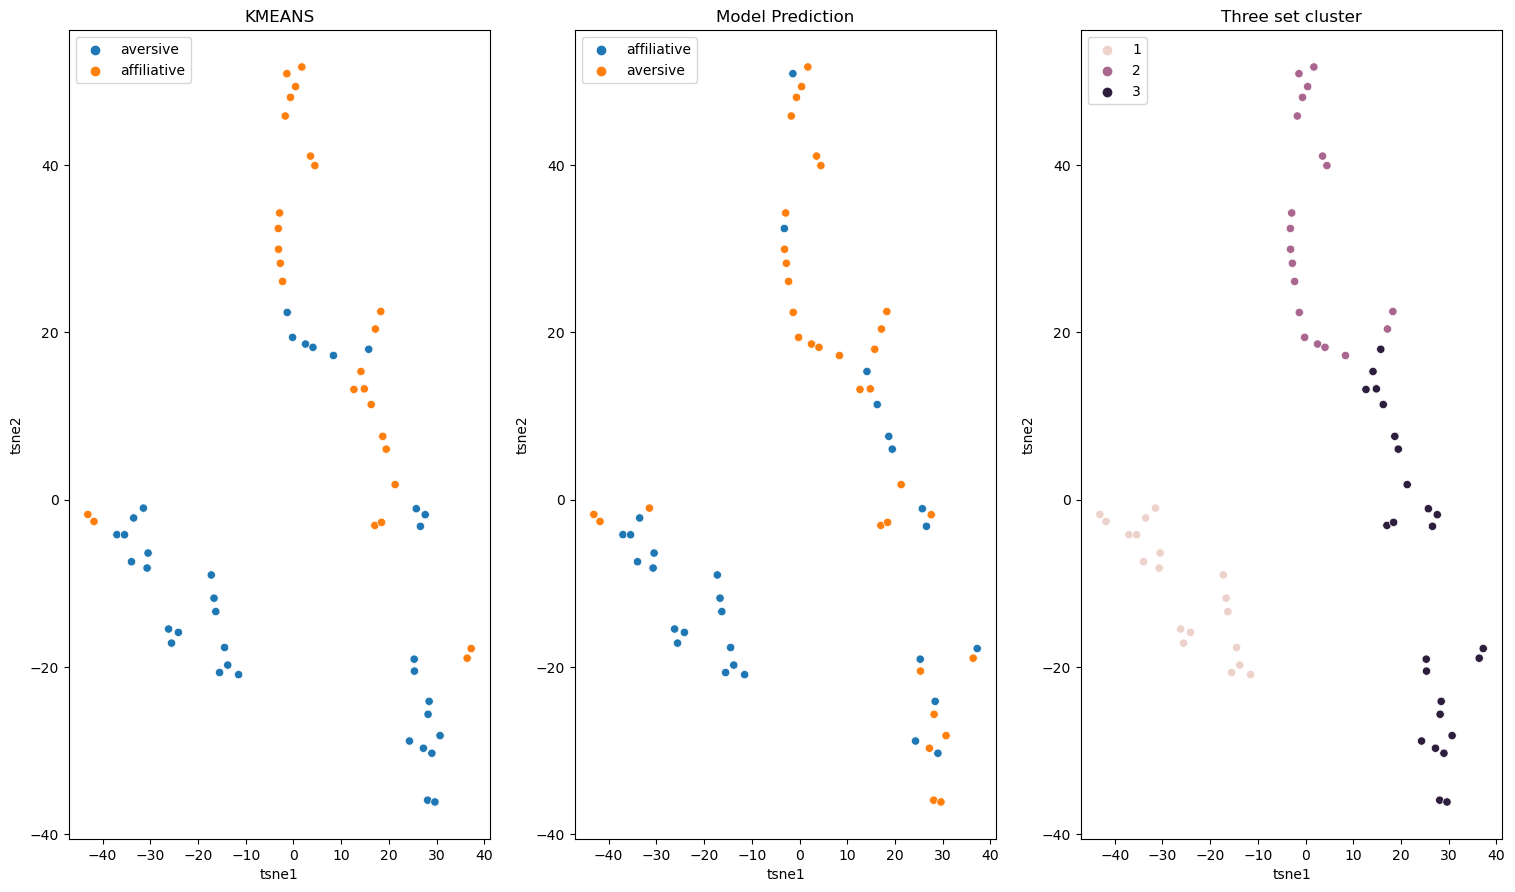

In [412]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18.5, 10.5)


x=df_clusters['tsne1']
y=df_clusters['tsne2']
sns.scatterplot(ax=ax1, data=df_clusters, x='tsne1', y='tsne2', hue='kmean_labeled')
ax1.title.set_text('KMEANS')
ax1.legend(loc='upper left')
sns.scatterplot(ax=ax2, data=df_clusters, x='tsne1', y='tsne2', hue='model_pred_1')
ax2.title.set_text('Model Prediction')
ax2.legend(loc='upper left')
sns.scatterplot(ax=ax3, data=df_clusters, x='tsne1', y='tsne2', hue='cluster')
ax3.title.set_text('Three set cluster')
ax3.legend(loc='upper left')

# 03/07/2023
Extract 3 kmeans clusters and create 3d tsne plot

In [413]:
df_clusters.columns

Index(['Unnamed:_0', 'sessions', 'rat_number', 'day_number', 'model_pred_1',
       'kmean_labeled', 'Interactions_Less_Than_6_sec',
       'Interactions_6_to_19_sec', 'Interactions_More_Than_19_sec',
       'Interactions_More_than_6_sec', 'Interactions_Total_time',
       'Intervals_Less_Than_5_sec', 'Intervals_5_to_20_sec',
       'Intervals_More_Than_20_sec', 'Intervals_All_intervals', 'cluster',
       'Interactions_Less_Than_6_sec_ratio', 'Interactions_6_to_19_sec_ratio',
       'Interactions_More_Than_19_sec_ratio',
       'Interactions_More_than_6_sec_ratio', 'Intervals_Less_Than_5_sec_ratio',
       'Intervals_5_to_20_sec_ratio', 'Intervals_More_Than_20_sec_ratio',
       'tsne1', 'tsne2'],
      dtype='object')

In [414]:
all_df.columns

Index(['coherence_AA_BMA_30_80Hz_enc_pre', 'coherence_AA_BMA_30_80Hz_post_pre',
       'coherence_AA_BMA_4_12Hz_enc_pre', 'coherence_AA_BMA_4_12Hz_post_pre',
       'coherence_AA_CeA_30_80Hz_enc_pre', 'coherence_AA_CeA_30_80Hz_post_pre',
       'coherence_AA_CeA_4_12Hz_enc_pre', 'coherence_AA_CeA_4_12Hz_post_pre',
       'coherence_AA_EA_30_80Hz_enc_pre', 'coherence_AA_EA_30_80Hz_post_pre',
       ...
       'lfp_MeD_4_12Hz_post_pre', 'lfp_MePV_30_80Hz_enc_pre',
       'lfp_MePV_30_80Hz_post_pre', 'lfp_MePV_4_12Hz_enc_pre',
       'lfp_MePV_4_12Hz_post_pre', 'rat_number', 'sociability',
       'y_pred_prob_1', 'model_pred_1', 'model_pred_2'],
      dtype='object', length=114)

In [1203]:
# vars = [
#     'Interactions_Less_Than_6_sec',
#     'Interactions_6_to_19_sec', 
#     'Interactions_More_Than_19_sec',
#     'Interactions_More_than_6_sec', 
#     'Interactions_Total_time',
    
#     'Intervals_Less_Than_5_sec',
#     'Intervals_5_to_20_sec',
#     'Intervals_More_Than_20_sec',
#     'Intervals_All_intervals',
    
#     'Interactions_Less_Than_6_sec_ratio',
#     'Interactions_6_to_19_sec_ratio',
#     'Interactions_More_Than_19_sec_ratio',
#     'Interactions_More_than_6_sec_ratio',
    
#     'Intervals_Less_Than_5_sec_ratio',
#     'Intervals_5_to_20_sec_ratio',
#     'Intervals_More_Than_20_sec_ratio']

vars = [
    'Interactions_Less_Than_6_sec',
    'Interactions_6_to_19_sec', 
    'Interactions_More_Than_19_sec',
    'Interactions_More_than_6_sec', 
    'Interactions_Total_time',
    
    'Intervals_Less_Than_5_sec',
    'Intervals_5_to_20_sec',
    'Intervals_More_Than_20_sec',
    'Intervals_All_intervals',
]


# vars = [
#     'Interactions_Total_time',   
#     'Intervals_5_to_20_sec',
# ]


# vars = vars_for_tsne
df_behavior = df_clusters[vars+['sessions']+['model_pred_1']].copy()

df_behavior['ratio'] = df_behavior['Intervals_5_to_20_sec']/df_behavior['Interactions_Total_time']

df_behavior = df_behavior.set_index('sessions')
df_behavior = df_behavior.join(all_df[['model_pred_2','y_pred_prob_1','y_pred_prob_2']])
df_behavior = df_behavior.reset_index()


In [1204]:
X_behavior_all = df_behavior[vars].values
scaler = StandardScaler()
X_behavior_all_scaled = scaler.fit_transform(X_behavior_all)




In [1210]:
n_components = 4
data = X_behavior_all_scaled
pca = PCA(n_components=n_components).fit(data)
with warnings.catch_warnings(record=True):
    kmeans = KMeans(init=pca.components_, n_clusters=n_components, n_init=1)
        
#     kmeans = KMeans(init='random', n_clusters=n_components, n_init=100)
    
    df_behavior['kmean3'] = [str(a) for a in kmeans.fit_predict(data)]



In [1211]:
# TSNE embedding
X_TSNE = TSNE(n_components=3, learning_rate='auto',
                  init='pca', perplexity=2).fit_transform(data)
df_behavior[['tsne3_1','tsne3_2','tsne3_3']] = X_TSNE
    
X_umap = UMAP(n_components=3, n_neighbors=8).fit_transform(data)
df_behavior[['umap1','umap2','umap3']] = X_umap

kmeans = KMeans(n_clusters=3, n_init=10)

#     kmeans = KMeans(init='random', n_clusters=n_components, n_init=100)

df_behavior['kmean3_umap'] = [str(a) for a in kmeans.fit_predict(X_umap)]



C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [1212]:
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# from sklearn.cluster import HDBSCAN

In [1213]:
level_column = 'model_pred_2'
column_name = 'kmean3'
class_counts = df_behavior.groupby([column_name, level_column]).size().reset_index(name='Count')
class_counts = class_counts.set_index([column_name,'model_pred_2']).unstack('model_pred_2')
class_counts.to_clipboard()
class_counts

Count         
model_pred_2 affiliative aversive
kmean3                           
0                      6        5
1                      3       12
2                      6       11
3                     17        3

Best Threshold: 0.675 with G-Mean: 0.8515
FPR: 0.0938, TPR: 0.8
({'F1': 0.8205128205128205, 'cappa': 0.7129337539432177, 'auc': 0.85}, 0.675)
Best Threshold: 0.555 with G-Mean: 0.7912
FPR: 0.1562, TPR: 0.7419
({'F1': 0.7586206896551724, 'cappa': 0.5545454545454546, 'auc': 0.7953629032258065}, 0.555)
Best Threshold: 0.675 with G-Mean: 0.8069
FPR: 0.186, TPR: 0.8
({'F1': 0.7272727272727272, 'cappa': 0.5827814569536424, 'auc': 0.7994186046511628}, 0.675)
         F1     cappa       auc
0  0.820513  0.712934  0.850000
1  0.758621  0.554545  0.795363
2  0.727273  0.582781  0.799419


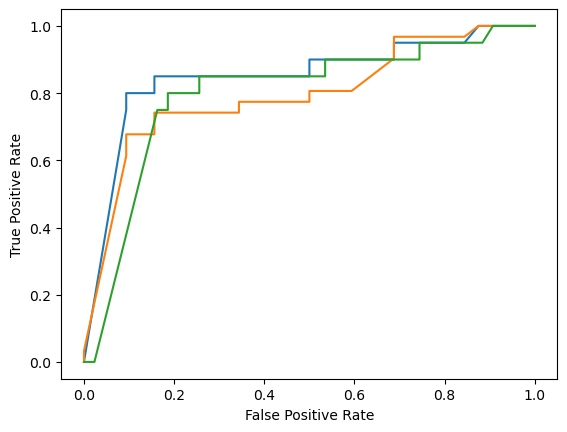

In [1217]:

clusterer = 'kmean3'
# clusterer = 'kmean3_umap'
model_num = 2
df_data = df_behavior.loc[df_behavior[clusterer].isin(['1','2','3'])]
# df_data = df_behavior
# y_pred_labels = np.array(df_data['model_pred_2'])=='affiliative'
# y_pred_labels = np.array(df_sum_ind['model_pred_1'])=='affiliative'
y_pred_prob = df_data[f'y_pred_prob_{model_num}'].values
# kmean_labels_logic = (df_behavior['kmean3']=='1')|(df_behavior['kmean3']=='2')
kmean_labels_logic = (df_data[clusterer]=='3')
res_1 = eval_model(y_pred_prob, kmean_labels_logic)
print(res_1)


# df_data = df_behavior.loc[df_behavior['kmean3'].isin(['0','2'])]
df_data = df_behavior
# y_pred_labels = np.array(df_data['model_pred_2'])=='affiliative'
# y_pred_labels = np.array(df_sum_ind['model_pred_1'])=='affiliative'
y_pred_prob = df_data[f'y_pred_prob_{model_num}'].values
kmean_labels_logic = (df_behavior[clusterer]=='0')|(df_behavior[clusterer]=='3')
# kmean_labels_logic = (df_data['kmean3']=='2')
res_2 = eval_model(y_pred_prob, kmean_labels_logic)
print(res_2)


# df_data = df_behavior.loc[df_behavior['kmean3'].isin(['0','2'])]
df_data = df_behavior
# y_pred_labels = np.array(df_data['model_pred_2'])=='affiliative'
# y_pred_labels = df_data['y_pred_prob_2'].values>0.675
# y_pred_labels = np.array(df_sum_ind['model_pred_1'])=='affiliative'
y_pred_prob = df_data[f'y_pred_prob_{model_num}'].values
# kmean_labels_logic = (df_behavior['kmean3']=='1')|(df_behavior['kmean3']=='2')
kmean_labels_logic = (df_data[clusterer]=='3')
res_3 = eval_model(y_pred_prob, kmean_labels_logic)
print(res_3)

ret_final = pd.DataFrame.from_dict([res_1[0],res_2[0],res_3[0]])
print(ret_final)
ret_final.to_clipboard()

In [1216]:
# Interactions_Total_time',   
#     'Intervals_5_to_20_sec
# sns.lmplot(data=df_behavior, x='Intervals_5_to_20_sec', y='Interactions_Total_time', hue='model_pred_2')
# sns.pairplot(data=df_behavior[['Interactions_Total_time','Intervals_5_to_20_sec','model_pred_2']], hue='model_pred_2')


In [1150]:
px.scatter_3d(df_behavior, x="umap1", y="umap2", z="umap3",
                         color="kmean3", hover_data=['sessions'],
                         color_discrete_map={'0': 'green', '1': 'blue', '2': 'red'},
                         opacity=0.8).update_traces(marker=dict(size=5))

# px.scatter_3d(df_behavior, x="tsne3_1", y="tsne3_2", z="tsne3_3",
#                          color="kmean3", hover_data=['sessions'],
#                          color_discrete_map={'0': 'green', '1': 'blue', '2': 'red'},
#                          opacity=0.8).update_traces(marker=dict(size=5))

In [1151]:
px.scatter_3d(df_behavior, x="umap1", y="umap2", z="umap3",
                         color="model_pred_2", hover_data=['sessions'],
                         opacity=0.8).update_traces(marker=dict(size=5))

In [1137]:
# Evaluate models

Best Threshold: 0.555 with G-Mean: 0.7912
FPR: 0.1562, TPR: 0.7419
({'F1': 0.7586206896551724, 'cappa': 0.5545454545454546, 'auc': 0.7953629032258065}, 0.555)


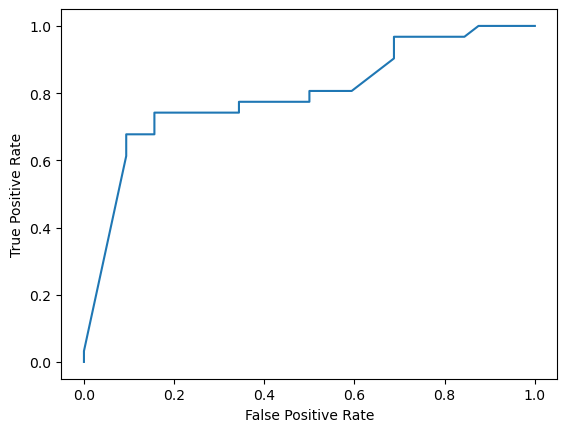

In [1079]:
kmean_labels_logic = (df_behavior['kmean3']=='3')|(df_behavior['kmean3']=='0')
# kmean_labels_logic = (df_behavior['kmean3']=='3')
res_1 = eval_model(y_pred_prob, kmean_labels_logic)
print(res_1)

In [1060]:
 df_behavior['kmean3'].value_counts().reset_index()

,index,kmean3
0,3,20
1,2,17
2,1,15
3,0,11


In [1200]:
import warnings

grouper = 'model_pred_2'
with warnings.catch_warnings(record=True):
    sig_tab = compare_groups(df_behavior[vars+[grouper]],grouper=grouper)
sig_tab.to_clipboard()
sig_tab

,variable,statistic,pvalue
1,Intervals_5_to_20_sec,686.5,0.008997
0,Interactions_Total_time,676.0,0.013593


In [1219]:
df_behavior['kmean3_added'] = (df_behavior['kmean3']=='3')
grouper = 'kmean3_added'
with warnings.catch_warnings(record=True):
    sig_tab = compare_groups(df_behavior[vars+[grouper]],grouper=grouper)
sig_tab.to_clipboard()
sig_tab

,variable,statistic,pvalue
6,Intervals_5_to_20_sec,75.0,1.654574e-07
0,Interactions_Less_Than_6_sec,181.0,2.432172e-04
8,Intervals_All_intervals,193.0,4.791478e-04
5,Intervals_Less_Than_5_sec,220.0,1.978555e-03
2,Interactions_More_Than_19_sec,551.5,1.674728e-02
3,Interactions_More_than_6_sec,558.0,5.974026e-02
1,Interactions_6_to_19_sec,533.5,1.282726e-01
7,Intervals_More_Than_20_sec,486.0,3.953994e-01
4,Interactions_Total_time,459.0,6.738792e-01


In [1174]:
# save_file_name = osp.join(folder_path,'df_bavior_clustering.xlsx')
# df_behavior.to_excel(save_file_name)

In [1166]:
df_behavior.columns

Index(['sessions', 'Interactions_Less_Than_6_sec', 'Interactions_6_to_19_sec',
       'Interactions_More_Than_19_sec', 'Interactions_More_than_6_sec',
       'Interactions_Total_time', 'Intervals_Less_Than_5_sec',
       'Intervals_5_to_20_sec', 'Intervals_More_Than_20_sec',
       'Intervals_All_intervals', 'model_pred_1', 'model_pred_2',
       'y_pred_prob_1', 'y_pred_prob_2', 'kmean3', 'umap1', 'umap2', 'umap3',
       'kmean3_umap', 'tsne3_1', 'tsne3_2', 'tsne3_3'],
      dtype='object')